In [1]:

from typing import Dict

import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses

from src.spectrogram import Spectrogram, split_spectrogram
from src.spectrum_painting import take_frequencies, downsample_spectrogram, augment_spectrogram, paint_spectrogram, \
    digitize_spectrogram

In [2]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [3]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

/Users/sethd/Desktop/spectrum-painting/src/spectrum_painting.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  scale: float = color_depth / max_value
/Users/sethd/Desktop/spectrum-painting/src/spectrum_painting.py:88: RuntimeWarning: invalid value encountered in multiply
  scaled_spectrogram = spectrogram * scale


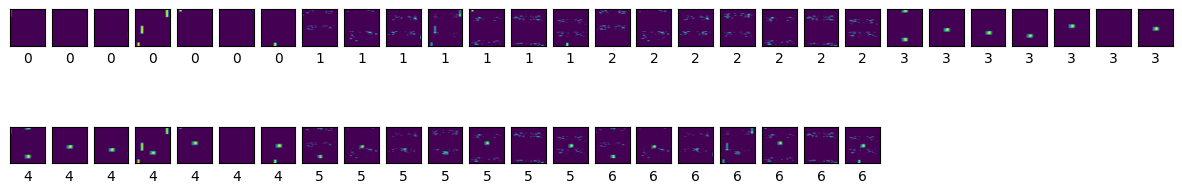

Number of training images: 34


In [4]:
from src.spectrogram import create_spectrogram

# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data_frames.items()}

downsample_resolution = 60

K = 3
L = 4
D = 1

color_depth = 256

x_train_augmented: [npt.NDArray[npt.NDArray[np.float32]]] = []
x_train_painted: [npt.NDArray[npt.NDArray[np.float32]]] = []
labels: [np.uint8] = []

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 30
    end_freq: int = middle + 30

    spec = take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=1000)

    downsampled_slices = [downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    for s in augmented_slices:
        x_train_augmented.append(digitize_spectrogram(s, color_depth))

    painted_slices = [paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    for s in painted_slices:
        x_train_painted.append(digitize_spectrogram(s, color_depth))

    for i in range(len(slices)):
        labels.append(class_index)

plt.figure(figsize=(15, 15))
for i in range(len(x_train_painted)):
    image = x_train_painted[i]
    plt.subplot(10, 28, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[i])
plt.show()

x_train_combined = np.stack((x_train_augmented, x_train_painted), axis=3)

x_train, x_test, y_train, y_test = train_test_split(x_train_combined, labels, test_size=0.3, random_state=42)

# for tensorflow it must be uint8 and not a Python int.
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

print(f"Number of training images: {len(x_train)}")


In [5]:
image_shape = x_train_augmented[0].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

augmented_input = layers.Input(shape=input_shape)
augmented_model = layers.Conv2D(filters=32, kernel_size=(7, 7), activation='relu')(augmented_input)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

# Flatten the 3D image output to 1 dimension
augmented_model = layers.Flatten()(augmented_model)

(60, 57, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 57, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60, 57, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 54, 51, 32)           1600      ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 54, 51, 32)           1600      ['input_2[0][0]']             
                                                                                              

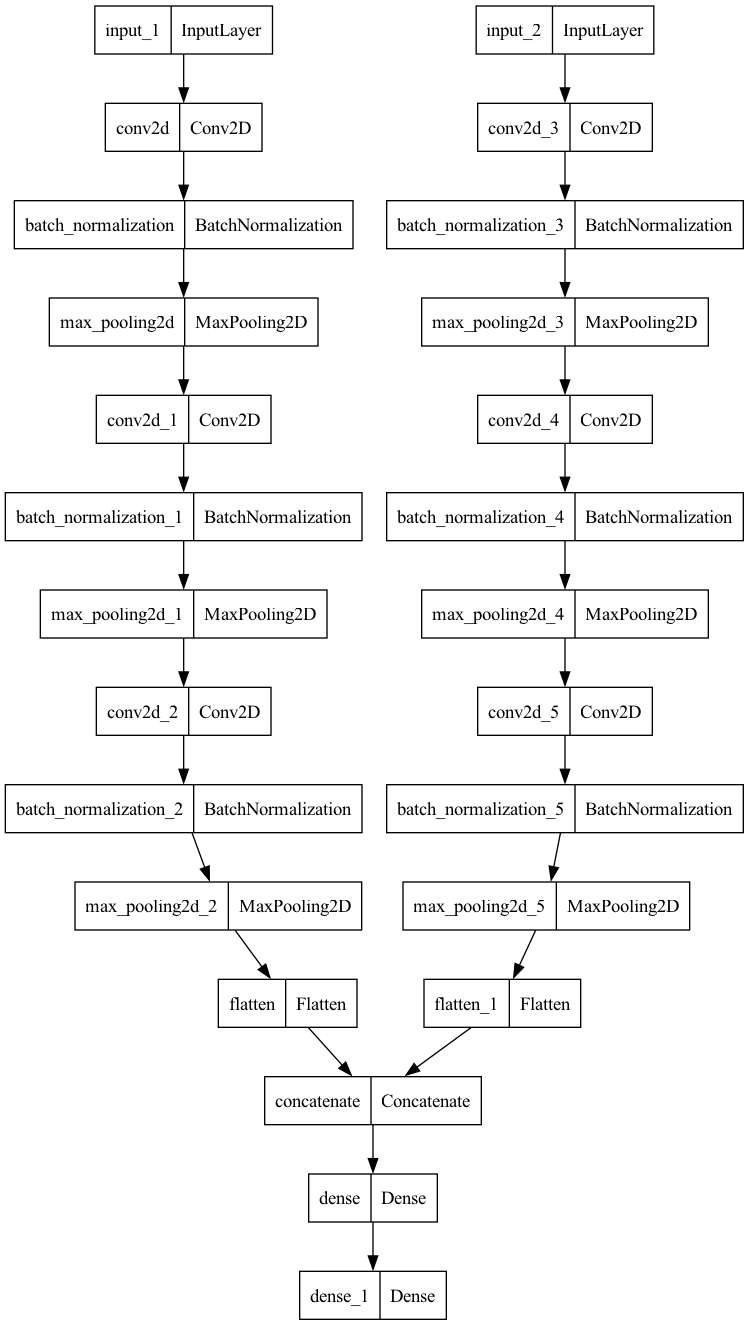

In [6]:
painted_input = layers.Input(shape=input_shape)
painted_model = layers.Conv2D(filters=32, kernel_size=(7, 7), activation='relu', input_shape=input_shape)(painted_input)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

# Flatten the 3D image output to 1 dimension
painted_model = layers.Flatten()(painted_model)

output = layers.Concatenate()([augmented_model, painted_model])
output = layers.Dense(64, activation='relu')(output)

label_count = len(spectrograms)
output = layers.Dense(label_count)(output)

model = models.Model(inputs=[augmented_input, painted_input], outputs=[output])

model.summary()
tf.keras.utils.plot_model(model)

Epoch 1/10
2/2 [==============================] - 1s 129ms/step - loss: 3.0094 - accuracy: 0.1471 - val_loss: 11.7095 - val_accuracy: 0.0667
Epoch 2/10
2/2 [==============================] - 0s 28ms/step - loss: 1.9406 - accuracy: 0.5294 - val_loss: 12.0201 - val_accuracy: 0.2000
Epoch 3/10
2/2 [==============================] - 0s 26ms/step - loss: 1.5064 - accuracy: 0.4412 - val_loss: 13.2850 - val_accuracy: 0.2000
Epoch 4/10
2/2 [==============================] - 0s 26ms/step - loss: 1.3848 - accuracy: 0.6176 - val_loss: 13.9257 - val_accuracy: 0.2000
Epoch 5/10
2/2 [==============================] - 0s 25ms/step - loss: 1.2968 - accuracy: 0.6471 - val_loss: 13.8616 - val_accuracy: 0.1333
Epoch 6/10
2/2 [==============================] - 0s 40ms/step - loss: 1.3491 - accuracy: 0.7647 - val_loss: 14.1229 - val_accuracy: 0.1333
Epoch 7/10
2/2 [==============================] - 0s 37ms/step - loss: 1.2083 - accuracy: 0.7059 - val_loss: 14.6825 - val_accuracy: 0.1333
Epoch 8/10
2/2 [===

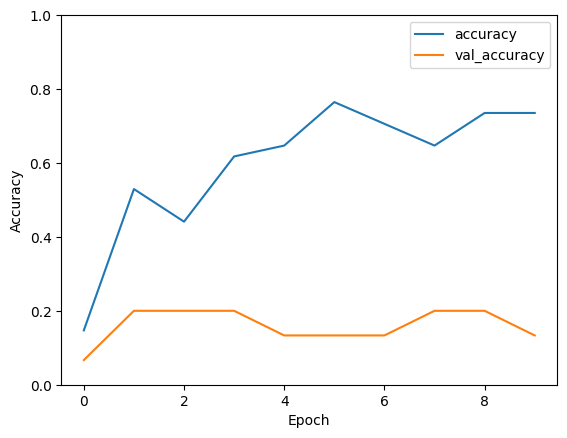

In [7]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# convert ints to the type of int that can be used in a Tensor
history = model.fit(x=[x_train_augmented, x_train_painted], y=y_train, epochs=10, verbose=1,
                    validation_data=([x_test_augmented, x_test_painted], y_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')

In [8]:
final_loss, final_acc = model.evaluate([x_test_augmented, x_test_painted], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc)) 

1/1 [==============================] - 0s 27ms/step - loss: 12.9202 - accuracy: 0.1333
Final loss: 12.920182, final accuracy: 0.133333


In [9]:
output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(model, "output/")
model.save(output_file)

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [15]:
# Convert the model
# This requires TensorFlow Lite 2.15.0 for it to work. See https://github.com/tensorflow/tensorflow/issues/63987
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
print("Converting...")
tflite_model = converter.convert()
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
  f.write(tflite_model)


Converting...
INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpa5z2aikp/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpa5z2aikp/assets


Done. Model size = 330 KB


2024-05-13 12:29:43.116357: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-13 12:29:43.116369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-13 12:29:43.116464: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpa5z2aikp
2024-05-13 12:29:43.118183: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-13 12:29:43.118188: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpa5z2aikp
2024-05-13 12:29:43.123234: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-13 12:29:43.191030: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpa5z2aikp
2024-05-